In [1]:
import sqlite3
import pandas as pd
import filterbyip as fbi
import clusterbycolumn as cbc
import requests
import asinfo

import matplotlib.dates as dates
from datetime import datetime as dt

In [2]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
def asn_from_probe_name(probe_name):
    base = 'http://leone-collector.eecs.jacobs-university.de/msmpoint'
    msm_metadata = requests.get('%s/%s'%(base, probe_name))
    asn4 = str(msm_metadata.json()['asn4'])
    asn6 = str(msm_metadata.json()['asn6'])
    return asn4,asn6

In [5]:
dailydb_location = '/data/vbajpai/datasets/youtube-data-collection-python3/youtube.db'

In [6]:
query = '''select   msmpoint.name as probe
                  , dtime
                  , video_address
                  , video_download_bytes_sec
                  , audio_download_bytes_sec
           from youtube, msmpoint
           where youtube.unit_id = msmpoint.skunitid
           and msmpoint.skunitid <> ''
           and successes = 1
           and failures = 0;
        '''

In [7]:
con = sqlite3.connect(dailydb_location)
df = pd.read_sql(query, con)

In [8]:
df.count()

probe                       4422465
dtime                       4422465
video_address               4422465
video_download_bytes_sec    4422465
audio_download_bytes_sec    4422465
dtype: int64

In [9]:
df.head()

,probe,dtime,video_address,video_download_bytes_sec,audio_download_bytes_sec
0,samsbox81,2016-09-05 16:29:41,193.212.4.15,2006335,1242187
1,samsbox81,2016-09-05 16:30:23,2001:4600:9:307::f,2032809,1146949
2,samsbox81,2016-09-05 17:26:17,193.212.4.15,1946785,1214358
3,samsbox81,2016-09-05 17:26:59,2001:4600:9:307::f,2008980,889966
4,samsbox81,2016-09-05 18:25:53,193.212.4.15,1927047,1181569


In [10]:
def round_time_to_nearest_hour(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d %H:%M:%S')
    return dtime

In [11]:
df['dtime'] = df['dtime'].apply(round_time_to_nearest_hour)

In [12]:
df.head()

,probe,dtime,video_address,video_download_bytes_sec,audio_download_bytes_sec
0,samsbox81,2016-09-05 16:00:00,193.212.4.15,2006335,1242187
1,samsbox81,2016-09-05 16:00:00,2001:4600:9:307::f,2032809,1146949
2,samsbox81,2016-09-05 17:00:00,193.212.4.15,1946785,1214358
3,samsbox81,2016-09-05 17:00:00,2001:4600:9:307::f,2008980,889966
4,samsbox81,2016-09-05 18:00:00,193.212.4.15,1927047,1181569


In [13]:
num_probes = len(set(df['probe']))

In [14]:
df.count()

probe                       4422465
dtime                       4422465
video_address               4422465
video_download_bytes_sec    4422465
audio_download_bytes_sec    4422465
dtype: int64

In [15]:
df = df.dropna()

In [16]:
df.count()

probe                       4422465
dtime                       4422465
video_address               4422465
video_download_bytes_sec    4422465
audio_download_bytes_sec    4422465
dtype: int64

In [17]:
df['v_MB_sec'] = df['video_download_bytes_sec'].div(1024).div(1024)
df['a_MB_sec'] = df['audio_download_bytes_sec'].div(1024).div(1024)

del df['video_download_bytes_sec']
del df['audio_download_bytes_sec']

In [18]:
def filter_by_ip(df, column):
  """reads a DataFrame, calls fbi.filter_v{4,6} to get DataFrames with rows
     containing only v4, v6 endpoints. Returns the two DataFrame as a tuple"""

  dfv6 = fbi.filter_v6(df, column)
  dfv4 = fbi.filter_v4(df, column)
  return dfv4, dfv6

In [19]:
dfv4, dfv6 = filter_by_ip(df, column = 'video_address')

In [20]:
dfv4['name'] = dfv4['probe'].apply(lambda name: "#%02d"%int(name[7:]))
dfv6['name'] = dfv6['probe'].apply(lambda name: "#%02d"%int(name[7:]))
del dfv4['probe']; del dfv6['probe']

In [21]:
dfv4.head()

,dtime,video_address,v_MB_sec,a_MB_sec,name
0,2016-09-05 16:00:00,193.212.4.15,1.913390,1.184642,#81
2,2016-09-05 17:00:00,193.212.4.15,1.856599,1.158102,#81
4,2016-09-05 18:00:00,193.212.4.15,1.837775,1.126832,#81
6,2016-09-05 19:00:00,193.212.4.15,1.906452,1.091392,#81
8,2016-09-05 20:00:00,193.212.4.15,1.896476,0.974868,#81


In [22]:
dfv6.head()

,dtime,video_address,v_MB_sec,a_MB_sec,name
1,2016-09-05 16:00:00,2001:4600:9:307::f,1.938638,1.093816,#81
3,2016-09-05 17:00:00,2001:4600:9:307::f,1.915913,0.848738,#81
5,2016-09-05 18:00:00,2001:4600:9:307::f,1.821363,1.107177,#81
7,2016-09-05 19:00:00,2001:4600:9:307::f,1.834697,1.188632,#81
9,2016-09-05 20:00:00,2001:4600:9:307::f,1.909348,0.801767,#81


In [23]:
df = pd.merge(dfv4, dfv6, on=["name", "dtime"])

In [24]:
df.count()

dtime              6581885
video_address_x    6581885
v_MB_sec_x         6581885
a_MB_sec_x         6581885
name               6581885
video_address_y    6581885
v_MB_sec_y         6581885
a_MB_sec_y         6581885
dtype: int64

In [25]:
df.head()

,dtime,video_address_x,v_MB_sec_x,a_MB_sec_x,name,video_address_y,v_MB_sec_y,a_MB_sec_y
0,2016-09-05 16:00:00,193.212.4.15,1.913390,1.184642,#81,2001:4600:9:307::f,1.938638,1.093816
1,2016-09-05 17:00:00,193.212.4.15,1.856599,1.158102,#81,2001:4600:9:307::f,1.915913,0.848738
2,2016-09-05 18:00:00,193.212.4.15,1.837775,1.126832,#81,2001:4600:9:307::f,1.821363,1.107177
3,2016-09-05 19:00:00,193.212.4.15,1.906452,1.091392,#81,2001:4600:9:307::f,1.834697,1.188632
4,2016-09-05 20:00:00,193.212.4.15,1.896476,0.974868,#81,2001:4600:9:307::f,1.909348,0.801767


In [26]:
df.rename(columns={  'video_address_x'      : 'video_ep_v4'
                   , 'v_MB_sec_x'           : 'v_MB_sec_v4'
                   , 'a_MB_sec_x'           : 'a_MB_sec_v4'                   
                   , 'video_address_y'      : 'video_ep_v6'
                   , 'v_MB_sec_y'           : 'v_MB_sec_v6'
                   , 'a_MB_sec_y'           : 'a_MB_sec_v6'                                      
                  } ,  inplace=True)

In [27]:
del df['video_ep_v4']; del df['video_ep_v6']

In [28]:
df.head()

,dtime,v_MB_sec_v4,a_MB_sec_v4,name,v_MB_sec_v6,a_MB_sec_v6
0,2016-09-05 16:00:00,1.913390,1.184642,#81,1.938638,1.093816
1,2016-09-05 17:00:00,1.856599,1.158102,#81,1.915913,0.848738
2,2016-09-05 18:00:00,1.837775,1.126832,#81,1.821363,1.107177
3,2016-09-05 19:00:00,1.906452,1.091392,#81,1.834697,1.188632
4,2016-09-05 20:00:00,1.896476,0.974868,#81,1.909348,0.801767


In [29]:
df.tail()

,dtime,v_MB_sec_v4,a_MB_sec_v4,name,v_MB_sec_v6,a_MB_sec_v6
6581880,2017-06-25 17:00:00,2.747395,1.138997,#91,2.712654,1.05301
6581881,2017-06-25 17:00:00,2.747395,1.138997,#91,2.712654,1.05301
6581882,2017-06-25 17:00:00,2.747395,1.138997,#91,2.712654,1.05301
6581883,2017-06-25 17:00:00,2.747395,1.138997,#91,2.712654,1.05301
6581884,2017-06-25 17:00:00,2.747395,1.138997,#91,2.712654,1.05301


In [30]:
df.count()

dtime          6581885
v_MB_sec_v4    6581885
a_MB_sec_v4    6581885
name           6581885
v_MB_sec_v6    6581885
a_MB_sec_v6    6581885
dtype: int64

In [31]:
df['v4v6_v_MB_sec'] = df.v_MB_sec_v4.map(str) + ',' + df.v_MB_sec_v6.map(str)
df['v4v6_a_MB_sec'] = df.a_MB_sec_v4.map(str) + ',' + df.a_MB_sec_v6.map(str)

In [32]:
df.count()

dtime            6581885
v_MB_sec_v4      6581885
a_MB_sec_v4      6581885
name             6581885
v_MB_sec_v6      6581885
a_MB_sec_v6      6581885
v4v6_v_MB_sec    6581885
v4v6_a_MB_sec    6581885
dtype: int64

### Calculate Absolute Difference

In [33]:
def get_difference(v4v6_throughput):
    
    v4, v6 = v4v6_throughput.split(',')
    try: v4 = float(v4); v6 = float(v6)
    except Exception as e: print(e, v4v6_throughput)
    
    difference = (v6 - v4) 
    return float('%0.2f'%difference)

df['v_MB_sec_a'] = df['v4v6_v_MB_sec'].apply(get_difference)
df['a_MB_sec_a'] = df['v4v6_a_MB_sec'].apply(get_difference)

### Calculate Relative Difference

In [34]:
def get_slowness(v4v6_throughput):
    
    v4, v6 = v4v6_throughput.split(',')
    try: v4 = float(v4); v6 = float(v6)
    except Exception as e: print(e, v4v6_throughput)
    
    try: slowness = (v6 - v4) / v4
    except Exception as e: return 0
    return float('%0.2f'%slowness)

df['v_MB_sec_r'] = df['v4v6_v_MB_sec'].apply(get_slowness)
df['a_MB_sec_r'] = df['v4v6_a_MB_sec'].apply(get_slowness)

In [35]:
del df['v4v6_a_MB_sec']; del df['v4v6_v_MB_sec']

In [36]:
def round_time_to_day(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(hour=0, minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d')
    return dtime

df['dtime'] = df['dtime'].apply(round_time_to_day)

In [37]:
df.count()

dtime          6581885
v_MB_sec_v4    6581885
a_MB_sec_v4    6581885
name           6581885
v_MB_sec_v6    6581885
a_MB_sec_v6    6581885
v_MB_sec_a     6581885
a_MB_sec_a     6581885
v_MB_sec_r     6581885
a_MB_sec_r     6581885
dtype: int64

In [38]:
targets = ['v_MB_sec_v4', 'a_MB_sec_v4', 
           'v_MB_sec_v6', 'a_MB_sec_v6',
           
           'v_MB_sec_a', 'a_MB_sec_a',
           'v_MB_sec_r', 'a_MB_sec_r' ,          
          ]

def get_throughput_across_probes(df):
    dfgroupby  = cbc.group(df, column=['dtime'])
    df_agg     = cbc.aggregate(dfgroupby, targets, ['median'])
    df_merged  = cbc.merge(df, df_agg, column=['dtime'])
    df         = df_merged.drop(targets + ['name'], axis=1)
    df         = df.drop_duplicates()
    df.columns = ['dtime'] + targets
    return df

df = get_throughput_across_probes(df)

In [39]:
df['dtime'] = df['dtime'].apply(lambda d: dt.strptime(d, '%Y-%m-%d'))

AttributeError: 'DataFrame' object has no attribute 'sort'

In [40]:
df.sort_values(by = 'dtime', inplace = True)

In [41]:
df.head()

,dtime,v_MB_sec_v4,a_MB_sec_v4,v_MB_sec_v6,a_MB_sec_v6,v_MB_sec_a,a_MB_sec_a,v_MB_sec_r,a_MB_sec_r
1592615,2014-08-21,0.923781,0.058216,0.023630,0.022566,-0.88,-0.04,-0.97,-0.615
1592625,2014-08-22,0.923466,0.058382,0.021913,0.021980,-0.88,-0.04,-0.98,-0.620
1592648,2014-08-23,0.924054,0.058375,0.021990,0.021621,-0.88,-0.04,-0.98,-0.630
1592671,2014-08-24,0.924189,0.058300,0.024550,0.025263,-0.88,-0.03,-0.97,-0.570
1592694,2014-08-25,0.822330,0.058096,0.026024,0.025701,-0.78,-0.03,-0.97,-0.565


In [42]:
df.tail()

,dtime,v_MB_sec_v4,a_MB_sec_v4,v_MB_sec_v6,a_MB_sec_v6,v_MB_sec_a,a_MB_sec_a,v_MB_sec_r,a_MB_sec_r
98576,2017-06-23,0.572040,0.756555,0.571938,0.724823,-0.00,-0.02,-0.00,-0.03
99176,2017-06-24,0.686526,0.745583,0.682394,0.686921,-0.00,-0.02,0.00,-0.03
99560,2017-06-25,1.531445,0.604259,1.496117,0.552988,-0.02,-0.03,-0.01,-0.04
99758,2017-06-26,2.026135,0.593721,2.069180,0.524764,-0.03,-0.03,-0.02,-0.05
99854,2017-06-27,1.193176,0.571957,1.172191,0.512903,-0.01,-0.02,-0.01,-0.04


In [43]:
df.count()

dtime          1040
v_MB_sec_v4    1040
a_MB_sec_v4    1040
v_MB_sec_v6    1040
a_MB_sec_v6    1040
v_MB_sec_a     1040
a_MB_sec_a     1040
v_MB_sec_r     1040
a_MB_sec_r     1040
dtype: int64

### Hardcoded dates

In [44]:
from dateutil import rrule
a=dt.strptime(str('2014-08-01'), '%Y-%m-%d')
b=dt.strptime(str('2017-07-01'), '%Y-%m-%d')
dateranges = rrule.rrule(rrule.DAILY, dtstart=a).between(a, b, inc=True)

In [46]:
df_ = pd.DataFrame(dateranges, columns=['dtime']).sort_values(by = 'dtime').reset_index(drop = True)
df = pd.merge(df_, df, how='outer')

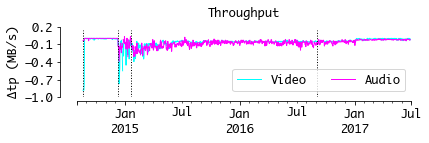

In [49]:
fig = plt.figure(figsize = (6, 1.3))
plt.rcParams['font.size'] = 12
ax = plt.gca()

sl = df.plot(  x='dtime'
             , y=['v_MB_sec_a', 'a_MB_sec_a']
             , color=['Cyan', 'Magenta']
             , kind='line'
             , linewidth = 1
             , ax = ax
            )

ax.grid(False)
ax.set_xlabel('', fontsize=22)
ax.set_ylabel('∆tp (MB/s)', fontsize=12)
ax.legend(['Video', 'Audio'], fontsize=12, loc='best', ncol = 2)
ax.set_yscale('linear')
ax.set_ylim([-1, 0.2])

yticks = np.arange(-1,0.3,0.3)
ax.set_yticks(yticks)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

from datetime import datetime as dt
ax.axvline(x=dt.strptime('2014-08-21', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax.axvline(x=dt.strptime('2014-12-10', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax.axvline(x=dt.strptime('2015-01-22', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax.axvline(x=dt.strptime('2016-09-05', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')

plt.title('Throughput', fontsize=12, y=1.05)
plt.savefig('youtube-audio-video-throughput-timeseries.pdf', format='pdf', bbox_inches='tight')